In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import datetime as dt
#import streamlit as st

In [ ]:
df = pd.read_excel('/content/Online Retail.xlsx')

In [ ]:
print(type(df))
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
df = df.dropna(subset=['CustomerID'])
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


**Create RFM Metrics:**

In [ ]:

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate Recency, Frequency, and Monetary Value
reference_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)  # Reference point for recency
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'Quantity': lambda x: (x * df['UnitPrice']).sum()  # Monetary value
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


<ipython-input-7-c434fd5f9a62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
df['CustomerID'].unique().shape
rfm.shape
df.shape
# Detect Negative quantities
dfx = df[df['Quantity'] <= 0]
dfx.shape

(8905, 8)

In [ ]:
# Remove negative values
df = df[df['Quantity'] > 0]

# Remove outliers
q1 = rfm['Monetary'].quantile(0.01)
q99 = rfm['Monetary'].quantile(0.99)
rfm = rfm[(rfm['Monetary'] >= q1) & (rfm['Monetary'] <= q99)]
print(rfm.shape)

(4286, 4)


**Feature Engineering**

In [ ]:
rfm['CLV'] = rfm['Monetary'] * rfm['Frequency']
rfm.head()

,CustomerID,Recency,Frequency,Monetary,CLV
0,12346.0,326,2,0.00,0.00
1,12347.0,2,7,4310.00,30170.00
2,12348.0,75,4,1797.24,7188.96
3,12349.0,19,1,1757.55,1757.55
4,12350.0,310,1,334.40,334.40


In [ ]:
print(rfm['CLV'].nunique())
print('Min=',rfm['CLV'].min())
print('Max=', rfm['CLV'].max())
print('Mode=', rfm['CLV'].mode())
print('Mean=', rfm['CLV'].mean())
print('Median=', rfm['CLV'].median())

4227
Min= 0.0
Max= 1499372.8000000003
Mode= 0    0.0
Name: CLV, dtype: float64
Mean= 15343.53046710219
Median= 1650.85


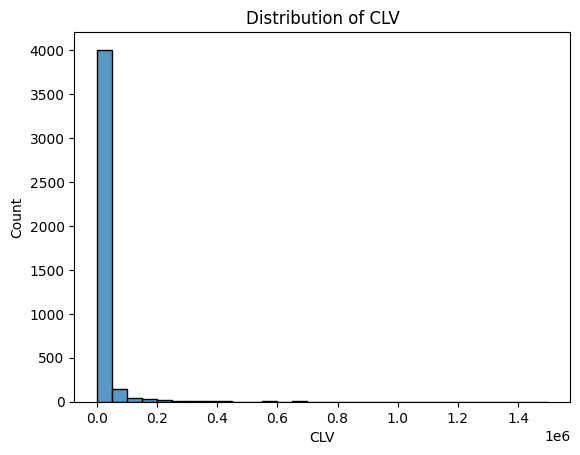

In [ ]:
sns.histplot(data=rfm, x='CLV', bins=30)
plt.title('Distribution of CLV')
plt.show()

In [ ]:
# Apply log transformation to the target variable (CLV)
rfm['log_CLV'] = np.log1p(rfm['CLV'])

In [ ]:
print(rfm['log_CLV'].nunique())
print('Min=',rfm['log_CLV'].min())
print('Max=', rfm['log_CLV'].max())
print('Mode=', rfm['log_CLV'].mode())
print('Mean=', rfm['log_CLV'].mean())
print('Median=', rfm['log_CLV'].median())

4210
Min= 0.0
Max= 14.220558112242303
Mode= 0    0.0
Name: log_CLV, dtype: float64
Mean= 7.560062154714045
Median= 7.409649599199522


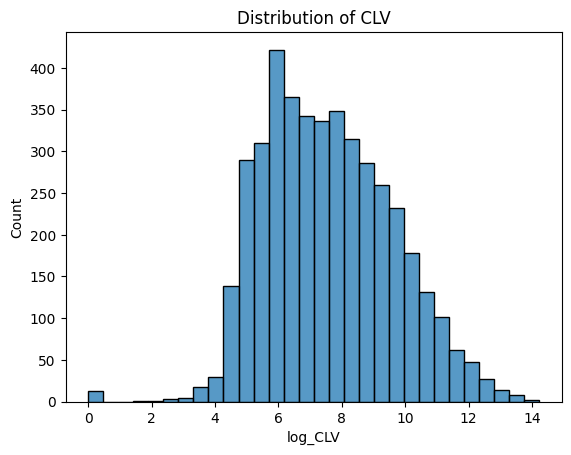

In [ ]:
sns.histplot(data=rfm, x='log_CLV', bins=30)
plt.title('Distribution of CLV')
plt.show()

**Normalize/Scale Data**

In [ ]:
scaler = MinMaxScaler()
rfm[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

**Building the Machine Learning Model**

In [ ]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['log_CLV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**Train a Model**

In [ ]:
model = RandomForestRegressor(n_estimators=150, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
#y_pred = np.expm1(y_pred_log)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae}, RMSE: {rmse}')

MAE: 0.009611350790094267, RMSE: 0.02591560393325214


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,CLV,log_CLV
0,12346.0,0.871314,0.007874,0.000000,0.00,0.000000
1,12347.0,0.002681,0.047244,0.252365,30170.00,10.314636
2,12348.0,0.198391,0.023622,0.105234,7188.96,8.880441
3,12349.0,0.048257,0.000000,0.102910,1757.55,7.472245
4,12350.0,0.828418,0.000000,0.019580,334.40,5.815324


In [ ]:
prediction = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

prediction.head()

,y_test,y_pred
3817,10.569831,10.568285
297,10.642137,10.589651
3639,6.957954,6.962733
2614,5.704715,5.704595
2139,9.375854,9.375930
